<a href="https://colab.research.google.com/github/seven320/-Target_on_with_Arduino/blob/master/shopee_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kill -9 $(lsof -t)

In [ ]:
#全てのデータを使って学習

In [1]:
import sys, os

In [2]:
from google.colab import drive
from google.colab import output
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!git clone https://github.com/rwightman/pytorch-image-models.git
path = "pytorch-image-models"
os.chdir(path)
output.clear()

In [4]:
! pip install albumentations==0.4.6
! pip install -U scikit-learn==0.24.0 # for stratified_group_kfold
output.clear()

In [5]:
import gc
import math
import os
import random
import time
from collections import Counter, defaultdict
from contextlib import contextmanager

import albumentations 
import cv2
# Work with phash

import numpy as np
import pandas as pd
import skimage.io as io
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer
from torch.utils.data import Dataset
from tqdm import tqdm
from tqdm.auto import tqdm as tqdmp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
# import cudf
# import cuml
import cupy
import timm
# from cuml.feature_extraction.text import TfidfVectorizer
# from cuml.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors

tqdmp.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
##########
## Utility ##
##########
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [52]:
class Config:
    # DATA_DIR = '../input/shopee-product-matching/train_images'
    # TRAIN_CSV = '../input/shopee-product-matching/train.csv'
    DATA_DIR = '/content/drive/MyDrive/kaggle/shopee/input/train_images'
    TRAIN_CSV = '/content/drive/MyDrive/kaggle/shopee/input/train.csv'
    MODEL_VER = '3.2'

    COMPUTE_VAL = False

    # IMG_SIZE = 512
    IMG_SIZE = 384
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    EPOCHS = 5  # Try 15 epochs
    BATCH_SIZE = 8

    NUM_WORKERS = 2
    DEVICE = 'cuda'

    CLASSES = 11014 
    SCALE = 30 
    MARGIN = 0.5

    # MODEL_NAME = 'eca_nfnet_l0'
    # MODEL_NAME = 'vit_base_patch16_224'
    MODEL_NAME = 'vit_base_patch16_384'
    FC_DIM = 512
    SCHEDULER_PARAMS = {
            "lr_start": 1e-5,
            "lr_max": 1e-5 * 32,
            "lr_min": 1e-6,
            "lr_ramp_ep": 5,
            "lr_sus_ep": 0,
            "lr_decay": 0.8,
        }

In [8]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

In [9]:
class ShopeeDataset(torch.utils.data.Dataset):

    def __init__(self,df, transform = None):
        self.df = df 
        self.root_dir = Config.DATA_DIR
        self.transform = transform

    def __len__(self):
        return len(self.df)
        # return 10000

    def __getitem__(self,idx):

        row = self.df.iloc[idx]

        img_path = os.path.join(self.root_dir,row.image)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = row.label_group

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return {
            'image' : image,
            'label' : torch.tensor(label).long()
            # 'label': torch.tensor(label).float()
        }

In [10]:
def get_train_transforms():
    return albumentations.Compose(
        [   
            albumentations.Resize(Config.IMG_SIZE,Config.IMG_SIZE,always_apply=True),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=120, p=0.8),
            albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
            albumentations.Normalize(mean = Config.MEAN, std = Config.STD),
            ToTensorV2(p=1.0),
        ]
    )

In [11]:
#credit : https://www.kaggle.com/tanulsingh077/pytorch-metric-learning-pipeline-only-images?scriptVersionId=58269290&cellId=22

class ShopeeScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ShopeeScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [12]:
#credit : https://github.com/Yonghongwei/Gradient-Centralization

def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x


class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=5, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False, gc_loc=True
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                # if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                # if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                # GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(G_grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [13]:
#credit : https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py

''' I just wanted to understand and implement custom backward activation in PyTorch so I choose this.
    You can also simply use this function below too.

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return input * (torch.tanh(F.softplus(input)))
'''

class Mish_func(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        print("Mish initialized")
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

In [14]:
def replace_activations(model, existing_layer, new_layer):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [15]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = (cosine * self.cos_m - sine * self.sin_m)
        if cosine.dtype == torch.float16:
            sine = sine.half()
            phi = phi.half()
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output, nn.CrossEntropyLoss()(output,label)

class ShopeeModel(nn.Module):

    def __init__(
        self,
        n_classes = Config.CLASSES,
        model_name = Config.MODEL_NAME,
        fc_dim = Config.FC_DIM,
        margin = Config.MARGIN,
        scale = Config.SCALE,
        use_fc = True,
        pretrained = True):

        super(ShopeeModel,self).__init__()
        # print('Building Model Backbone for {} model'.format(model_name))
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        self.model_name = model_name
        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        elif 'vit' in model_name:
            final_in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
            # self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        logits = self.final(feature,label)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        if 'vit' not in self.model_name:
            x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [16]:
def train_fn(model, data_loader, optimizer, scaler, scheduler, i):
    model.train()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [TRAIN] " + str(i+1))

    for t,data in enumerate(tk):
        for k,v in data.items():
            data[k] = v.to(Config.DEVICE)
        with autocast():
            optimizer.zero_grad()
            _, loss = model(**data)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # loss.backward()
            # optimizer.step() 
            fin_loss += loss.item() 

            tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1)), 'LR' : optimizer.param_groups[0]['lr']})

    scheduler.step()

    return fin_loss / len(data_loader)

def eval_fn(model, data_loader, i):
    model.eval()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [VALID] " + str(i+1))

    with torch.no_grad():
        for t,data in enumerate(tk):
            for k,v in data.items():
                data[k] = v.to(Config.DEVICE)
            _, loss = model(**data)
            fin_loss += loss.item() 

            tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1))})
        return fin_loss / len(data_loader)

In [17]:
###########
## scoring ##
###########
def get_image_predictions(df, embeddings,threshold = 0.0):
    
    if len(df) > 3:
        KNN = 50
    else : 
        KNN = 3
    
    model = NearestNeighbors(n_neighbors = KNN, metric = 'cosine')
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    predictions = []
    for k in tqdm(range(embeddings.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = df['posting_id'].iloc[ids].values
        predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return predictions

In [18]:
def get_test_transforms():

    return albumentations.Compose(
        [
            albumentations.Resize(Config.IMG_SIZE,Config.IMG_SIZE,always_apply=True),
            albumentations.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

In [19]:
class TestShopeeDataset(Dataset):
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.augmentations = transforms
        self.root_dir = Config.DATA_DIR

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_paths[index])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
    
        return image,torch.tensor(1)


class TestShopeeModel(nn.Module):

    def __init__(
        self, model_name,
        n_classes = Config.CLASSES,
        fc_dim = 512,
        margin = Config.MARGIN,
        scale = Config.SCALE,
        use_fc = True,
        pretrained = False):

        super(TestShopeeModel,self).__init__()
        # print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        self.model_name = model_name
        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'efficientnet_b3':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif model_name == 'tf_efficientnet_b5_ns':
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif model_name == 'eca_nfnet_l0':
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        elif model_name == 'vit_base_patch16_224':
            final_in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()

        elif model_name == 'vit_base_patch16_384':
            final_in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()

        self.pooling = nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        self.dropout = nn.Dropout(p=0.0)
        self.fc = nn.Linear(final_in_features, fc_dim)
        self.bn = nn.BatchNorm1d(fc_dim)
        self._init_params()
        final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        #logits = self.final(feature,label)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        if 'vit' not in self.model_name:
           x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [20]:
def get_image_embeddings(image_paths, model_name, model_path):
    embeds = []
    
    model = TestShopeeModel(model_name=model_name)
    model.eval()
    
    if model_name == 'eca_nfnet_l0':
        model = replace_activations(model, torch.nn.SiLU, Mish())

    model.load_state_dict(torch.load(model_path))
    model = model.to(Config.DEVICE)

    image_dataset = TestShopeeDataset(image_paths, transforms=get_test_transforms())
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=Config.BATCH_SIZE,
        pin_memory=True,
        drop_last=False,
        num_workers=1
    )
    
    with torch.no_grad():
        for img,label in tqdm(image_loader): 
            img = img.cuda()
            label = label.cuda()
            feat = model(img,label)
            image_embeddings = feat.detach().cpu().numpy()
            embeds.append(image_embeddings)
    
    del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

In [21]:
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

def cal_score(df, model, threshold = 0.3):
    image_embeddings = get_image_embeddings(df.image.values, Config.MODEL_NAME, model)

    image_predictions = get_image_predictions(df, image_embeddings, threshold)
    
    tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
    df["target"] = df.label_group.map(tmp)
    df['oof'] = image_predictions
    df["f1"] = df.apply(getMetric("oof"), axis = 1)
    print(f'threshold: {threshold}, CV Score ={df.f1.mean()}')
    return df.f1.mean()

In [57]:
def mkdir_save_model(model, epoch):
    if not os.path.isdir(f"/content/drive/MyDrive/kaggle/shopee/model/{Config.MODEL_VER}"):
        os.mkdir(f"/content/drive/MyDrive/kaggle/shopee/model/{Config.MODEL_VER}")

    torch.save(model.to("cpu").state_dict(),f"/content/drive/MyDrive/kaggle/shopee/model/{Config.MODEL_VER}/arcface_512x512_nfnet_l0(mish)_epoch{epoch}.pt")

    return f"/content/drive/MyDrive/kaggle/shopee/model/{Config.MODEL_VER}/arcface_512x512_nfnet_l0(mish)_epoch{epoch}.pt"

In [58]:
class Log:
    def __init__(self):
        # self.train_loss_scores = []
        self.train_f1_scores = {}
        self.val_f1_scores = {}

        for epoch in range(Config.EPOCHS):
            self.train_f1_scores[epoch] = {}
            self.val_f1_scores[epoch] = {}

In [59]:
def run_training():
    print(f"MODEL VER:{Config.MODEL_VER}")
    df = pd.read_csv(Config.TRAIN_CSV) 
    # df = df[:2000]

    labelencoder= LabelEncoder()
    df['label_group'] = labelencoder.fit_transform(df['label_group'])

    if Config.COMPUTE_VAL:
        groupkfold = GroupKFold(n_splits = 3)
        for fold, (train_idx, valid_idx) in enumerate(groupkfold.split(df, None, df.label_group)):
            break
    else:
        train_idx = df.index
        valid_idx = []

    trainset = ShopeeDataset(df.iloc[train_idx], transform = get_train_transforms())
    valset = ShopeeDataset(df.iloc[valid_idx], transform = get_train_transforms())

    print(f"train data cnt: {len(trainset)}, val data cnt: {len(valset)}")
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size = Config.BATCH_SIZE,
        pin_memory = True,
        num_workers = Config.NUM_WORKERS,
        shuffle = True,
        drop_last = True
    )
    valloader = torch.utils.data.DataLoader(
        valset,
        batch_size = Config.BATCH_SIZE,
        pin_memory = True,
        num_workers = Config.NUM_WORKERS,
        shuffle = False,
        drop_last = True
    )

    scaler = GradScaler()
    model = ShopeeModel()
    model.to(Config.DEVICE)
    
    existing_layer = torch.nn.SiLU
    new_layer = Mish()
    model = replace_activations(model, existing_layer, new_layer) # in eca_nfnet_l0 SiLU() is used, but it will be replace by Mish()
    
    optimizer = Ranger(model.parameters(), lr = Config.SCHEDULER_PARAMS['lr_start'])
    scheduler = ShopeeScheduler(optimizer,**Config.SCHEDULER_PARAMS)

    log = Log()
    for epoch in range(Config.EPOCHS):
        model.to(Config.DEVICE)
        with timer(f"epoch {epoch} TRAIN"):
            avg_loss_train = train_fn(model, trainloader, optimizer, scaler, scheduler, epoch)
            model_path = mkdir_save_model(model, epoch)
            train_f1_score = cal_score(df.iloc[train_idx].reset_index(drop=1), model_path)
            log.train_f1_scores[epoch][0.3] = train_f1_score
        if Config.COMPUTE_VAL:
            with timer(f"epoch {epoch} VALIDATE"):
                # avg_loss_val = eval_fn(model, valloader, epoch)
                val_f1_score = cal_score(df.iloc[valid_idx].reset_index(drop=1), model_path)
                log.val_f1_scores[epoch][0.3] = val_f1_score
    return log

log = run_training()

MODEL VER:3.2
train data cnt: 34250, val data cnt: 0
Mish initialized
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
[epoch 0 TRAIN] start



Our image embeddings shape is (34250, 512)



threshold: 0.3, CV Score =0.5396912300260612
[epoch 0 TRAIN] done - elapsed 7329.96s
[epoch 1 TRAIN] start



Our image embeddings shape is (34250, 512)



threshold: 0.3, CV Score =0.6552250408748723
[epoch 1 TRAIN] done - elapsed 1573.56s
[epoch 2 TRAIN] start



Our image embeddings shape is (34250, 512)



threshold: 0.3, CV Score =0.7436422863016371
[epoch 2 TRAIN] done - elapsed 1622.25s
[epoch 3 TRAIN] start



Our image embeddings shape is (34250, 512)



threshold: 0.3, CV Score =0.7751729612161197
[epoch 3 TRAIN] done - elapsed 1647.35s
[epoch 4 TRAIN] start



Our image embeddings shape is (34250, 512)



threshold: 0.3, CV Score =0.801961130287236
[epoch 4 TRAIN] done - elapsed 1660.08s


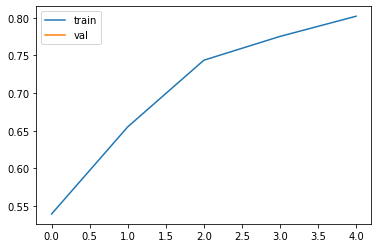

In [60]:
def show_result(log):
    threshold = 0.3
    train_f1_scores = []
    val_f1_scores = []
    for epoch in range(Config.EPOCHS):
        train_f1_scores.append(log.train_f1_scores[epoch][threshold])
        # val_f1_scores.append(log.val_f1_scores[epoch][threshold])
    plt.plot(train_f1_scores, label = "train")
    plt.plot(val_f1_scores, label = "val")
    plt.legend()
    plt.show()

show_result(log)

In [25]:

df = pd.read_csv(Config.TRAIN_CSV) 

In [26]:
df

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


In [28]:
df.iloc[df.index]

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


In [50]:
from sklearn.model_selection import KFold
groupkfold = KFold(n_splits = 2)
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
groupkfold.get_n_splits()

2

In [51]:
for train_idx, validx in groupkfold.split(X):
    print(train_idx)


[2 3]
[0 1]


In [ ]:
for train_idx, val_idx in gk.split(X)
